## Descrete Bayseian Network built on Titanic.csv

#### This is code from my final project / presentation in my Foundations of Data Modeling course

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'O', 'portembarked': 'O', 'fare': 'O', 'numparentschildren': 'O', 'passengerclass': 'O', 'sex': 'O', 'numsiblings': 'O', 'survived': 'O'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'O', 'portembarked': 'O', 'fare': 'O', 'numparentschildren': 'O', 'passengerclass': 'O', 'sex': 'O', 'numsiblings': 'O', 'survived': 'O'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'O', 'portembarked': 'O', 'fare': 'O', 'numparentschildren': 'O', 'passengerclass': 'O', 'sex': 'O', 'numsiblings': 'O', 'survived': 'O'}


  0%|          | 0/1000000 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'O', 'portembarked': 'O', 'fare': 'O', 'numparentschildren': 'O', 'passengerclass': 'O', 'sex': 'O', 'numsiblings': 'O', 'survived': 'O'}


Learned structure edges:
[('portembarked', 'age'), ('fare', 'portembarked'), ('fare', 'sex'), ('fare', 'passengerclass'), ('numparentschildren', 'numsiblings'), ('passengerclass', 'survived'), ('sex', 'survived'), ('sex', 'age'), ('sex', 'portembarked'), ('numsiblings', 'fare')]
-5433.54281239915
P(survived | sex, passengerclass):

P(survived) based on {'sex': 'low', 'passengerclass': 'low'}:
+------------------+-----------------+
| survived         |   phi(survived) |
+==================+=================+
| survived(high)   |          0.1193 |
+------------------+-----------------+
| survived(low)    |          0.8515 |
+------------------+-----------------+
| survived(medium) |          0.0292 |
+------------------+-----------------+

P(survived) based on {'sex': 'low', 'passengerclass': 'medium'}:
+------------------+-----------------+
| survived         |   phi(survived) |
+==================+=================+
| survived(high)   |          0.2193 |
+------------------+-----------

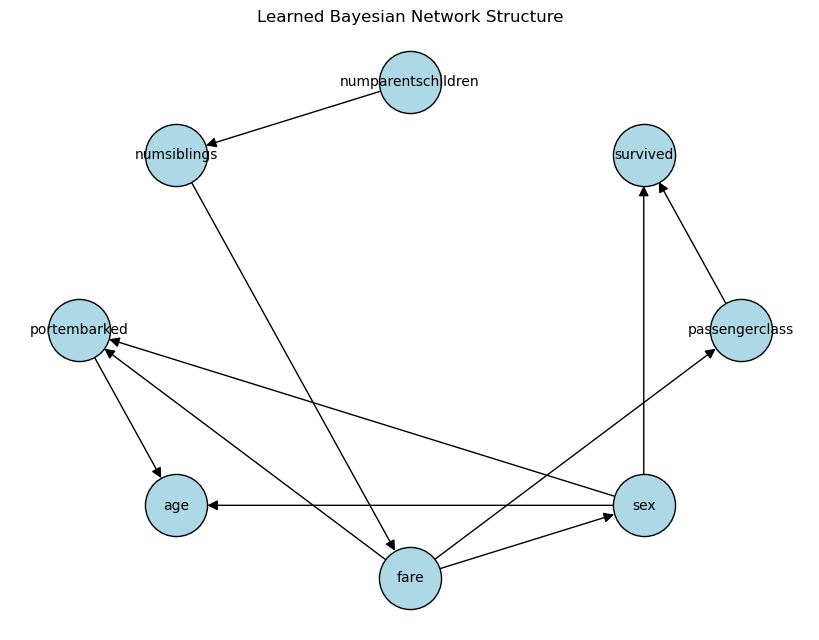

In [ ]:
import pandas as pd
from pgmpy.estimators import HillClimbSearch, BayesianEstimator, BIC
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination
import networkx as nx
import matplotlib.pyplot as plt

# --- Load dataset ---
data = pd.read_csv("titanic.csv")

# --- Select columns ---
cols = ["age","portembarked","fare","numparentschildren","passengerclass","sex","numsiblings","survived"]
data = data[cols].dropna()

# --- Discretize continuous variables ---
# Discretizing every variable into three bins as an odd choice I admit, and it would've been better to do it
# another way, but it was a fun experiment and did not hurt the results in any major way
for c in data.columns:
    data[c] = pd.qcut(data[c].rank(method="first"), q=3, labels=["low", "medium", "high"])

# --- Learn structure using Hill Climb + BDeu score ---
hc = HillClimbSearch(data)
score = BIC(data)
best_model = hc.estimate(scoring_method=score)

print("Learned structure edges:")
print(best_model.edges())

# --- Fit parameters ---
model = DiscreteBayesianNetwork(best_model.edges())
model.fit(data, estimator=BayesianEstimator, prior_type="BDeu")
print(score.score(model))

# --- Inference on survival for all possible scenarios (sex & passengerClass) ---
# note: this was so insanely unnecesarry but its whatever lol
# this is just doing what the heatmap is doing but like kinda worse
# it also looks clunky when printed but hey i did it and fixed it with a heatmap

scenarios = [
    {"sex": "low", "passengerclass": "low"},
    {"sex": "low", "passengerclass": "medium"},
    {"sex": "low", "passengerclass": "high"},
    {"sex": "medium", "passengerclass": "low"},
    {"sex": "medium", "passengerclass": "medium"},
    {"sex": "medium", "passengerclass": "high"},
    {"sex": "high", "passengerclass": "low"},
    {"sex": "high", "passengerclass": "medium"},
    {"sex": "high", "passengerclass": "high"},
]

infer = VariableElimination(model)

print("P(survived | sex, passengerclass):\n")
for ev in scenarios:
    q = infer.query(variables=["survived"], evidence=ev)
    #print(f"Evidence: {ev} --> P(survived):\n{q}\n")
    print(F"P(survived) based on {ev}:\n{q}\n")


# --- Visualize network ---
G = nx.DiGraph()
G.add_edges_from(model.edges())

plt.figure(figsize=(8, 6))
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue",
        font_size=10, arrows=True, arrowsize=15, edgecolors="black")

plt.title("Learned Bayesian Network Structure")
plt.show()


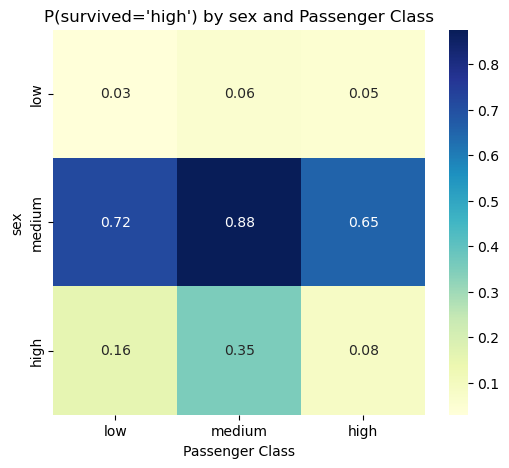

In [2]:
import seaborn as sns
import numpy as np

# --- Define categories ---
sex_levels = ["low", "medium", "high"]
class_levels = ["low", "medium", "high"]

# --- Prepare a matrix to store P(survived='high') for each combination ---
prob_matrix = np.zeros((len(sex_levels), len(class_levels)))

infer = VariableElimination(model)

for i, sex in enumerate(sex_levels):
    for j, pclass in enumerate(class_levels):
        q = infer.query(variables=["survived"], evidence={"sex": sex, "passengerclass": pclass})
        prob_matrix[i, j] = q.values[2]

# --- Convert to DataFrame for easier plotting ---
heatmap_data = pd.DataFrame(prob_matrix, index=sex_levels, columns=class_levels)

# --- Plot heatmap ---
plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("P(survived='high') by sex and Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("sex")
plt.show()
